In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys

if "../" not in sys.path:
    sys.path.append("../")
    print("[sys.path]:", sys.path)

In [7]:
import tqdm

from src.data.babel import BabelDataset, PromptGenerationMode

In [51]:
from src.data.filtering import (
    FilterConfig,
    no_transition_filter_fn_factory,
    create_locate_classes_filter_fn,
)

In [ ]:
filter_config = FilterConfig(
    min_motion_frames=1,
    max_motion_frames=2048,
    min_prompts_per_sample=1,
    max_prompts_per_sample=8,
    prompt_text_filter_fn=no_transition_filter_fn_factory(),
    min_span_frames=1,
    max_span_frames=32,
    max_spans_per_prompt=4,
    debug=False,
)

babel_train_dataset = BabelDataset(
    split="train",
    split_prompts_types=False,
    mode=PromptGenerationMode.FRAME_ANNOTATIONS,
    fps=20,
    padding_value=0.0,
    use_filtering=True,
    filter_config=filter_config
)

babel_validation_dataset = BabelDataset(
    split="validation",
    split_prompts_types=False,
    mode=PromptGenerationMode.FRAME_ANNOTATIONS,
    fps=20,
    padding_value=0.0,
    use_filtering=True,
    filter_config=filter_config
)

Repo card metadata block was not found. Setting CardData to empty.
Map: 100%|██████████| 6615/6615 [05:28<00:00, 20.17 examples/s]
Repo card metadata block was not found. Setting CardData to empty.
Map: 100%|██████████| 2193/2193 [01:58<00:00, 18.48 examples/s]


In [43]:
print("[#babel-train]", len(babel_train_dataset))
print("[#babel-validation]", len(babel_validation_dataset))

[#babel-train] 3670
[#babel-validation] 1242


In [45]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import concatenate_datasets
from collections import Counter, defaultdict

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [47]:
train_data = babel_train_dataset.dataset
validation_data = babel_validation_dataset.dataset

combined_dataset = concatenate_datasets([train_data, validation_data])

print(f"[#dataset]:", len(combined_dataset))

[#dataset]: 4912


<div class="alert alert-warning">

TODO: add box plots to better visualize the distribution.

</div>

In [48]:
motion_durations = []
for sample in tqdm.tqdm(combined_dataset, desc="[extracting-motion-durations]"):
    motion_frames = len(sample["motion"]["new_joints"])
    motion_durations.append(motion_frames)

motion_durations = np.array(motion_durations)

[extracting-motion-durations]: 100%|██████████| 4912/4912 [04:42<00:00, 17.38it/s]


Total motions: 8808
Average motion duration: 244.88 frames
Median motion duration: 130.00 frames
Min motion duration: 1 frames
Max motion duration: 5272 frames
Std motion duration: 330.08 frames


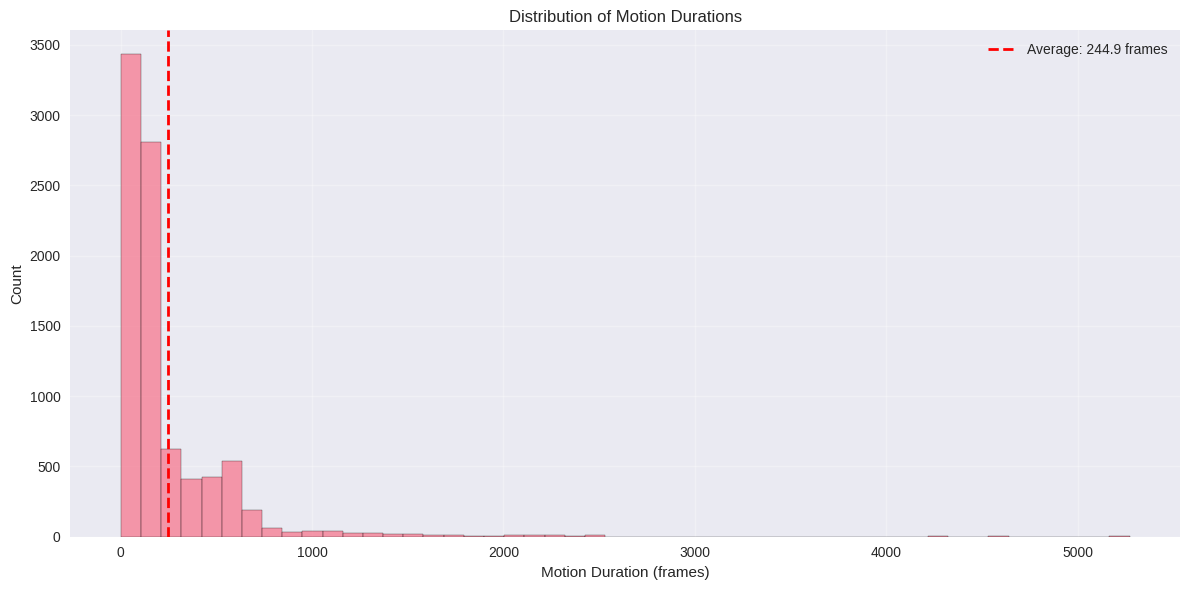

In [21]:
print(f"Total motions: {len(motion_durations)}")
print(f"Average motion duration: {motion_durations.mean():.2f} frames")
print(f"Median motion duration: {np.median(motion_durations):.2f} frames")
print(f"Min motion duration: {motion_durations.min()} frames")
print(f"Max motion duration: {motion_durations.max()} frames")
print(f"Std motion duration: {motion_durations.std():.2f} frames")

plt.figure(figsize=(12, 6))
plt.hist(motion_durations, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(motion_durations.mean(), color='red', linestyle='--', linewidth=2, label=f'Average: {motion_durations.mean():.1f} frames')
plt.xlabel('Motion Duration (frames)')
plt.ylabel('Count')
plt.title('Distribution of Motion Durations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
def extract_spans_from_annotations(annotations, fps=20):
    """Extract spans from annotations (sequence or frame)"""
    spans = []
    if 'labels' in annotations and annotations['labels']:
        labels = annotations['labels']
        
        # Handle both list and dict formats
        if isinstance(labels, list):
            # Already in row format
            for label in labels:
                if 'start_t' in label and 'end_t' in label:
                    start_frame = int(label['start_t'] * fps)
                    end_frame = int(label['end_t'] * fps)
                    spans.append((start_frame, end_frame))
        elif isinstance(labels, dict):
            # Column format - need to transpose
            if 'start_t' in labels and 'end_t' in labels:
                start_times = labels['start_t']
                end_times = labels['end_t']
                for start_t, end_t in zip(start_times, end_times):
                    start_frame = int(start_t * fps)
                    end_frame = int(end_t * fps)
                    spans.append((start_frame, end_frame))
    return spans

all_span_durations = []
num_prompts_per_motion = []
num_spans_per_motion = []
num_spans_per_prompt = []
all_prompt_texts = []

for sample in tqdm.tqdm(combined_dataset, desc="Extracting span information"):
    # Extract spans from both sequence and frame annotations
    seq_spans = extract_spans_from_annotations(sample['sequence_annotations'], fps=20)
    frame_spans = extract_spans_from_annotations(sample['frame_annotations'], fps=20)
    
    # Combine all spans for this motion
    all_spans = seq_spans + frame_spans
    
    # Calculate span durations
    span_durations_this_motion = []
    for start_frame, end_frame in all_spans:
        duration = end_frame - start_frame
        if duration > 0:  # Only positive durations
            span_durations_this_motion.append(duration)
            all_span_durations.append(duration)
    
    # Count spans per motion
    num_spans_per_motion.append(len(span_durations_this_motion))
    
    # Extract prompt texts and count prompts
    motion_prompts = []
    
    # From sequence annotations
    seq_labels = sample['sequence_annotations'].get('labels', [])
    if isinstance(seq_labels, list):
        for label in seq_labels:
            if 'proc_label' in label:
                motion_prompts.append(label['proc_label'])
                all_prompt_texts.append(label['proc_label'])
    elif isinstance(seq_labels, dict) and 'proc_label' in seq_labels:
        for prompt in seq_labels['proc_label']:
            motion_prompts.append(prompt)
            all_prompt_texts.append(prompt)
    
    # From frame annotations
    frame_labels = sample['frame_annotations'].get('labels', [])
    if isinstance(frame_labels, list):
        for label in frame_labels:
            if 'proc_label' in label:
                motion_prompts.append(label['proc_label'])
                all_prompt_texts.append(label['proc_label'])
    elif isinstance(frame_labels, dict) and 'proc_label' in frame_labels:
        for prompt in frame_labels['proc_label']:
            motion_prompts.append(prompt)
            all_prompt_texts.append(prompt)
    
    num_prompts_per_motion.append(len(motion_prompts))
    
    # For spans per prompt, we assume each prompt has one span (could be more complex)
    if len(motion_prompts) > 0:
        spans_per_prompt = len(all_spans) / len(motion_prompts)
        num_spans_per_prompt.append(spans_per_prompt)

# Convert to numpy arrays
all_span_durations = np.array(all_span_durations)
num_prompts_per_motion = np.array(num_prompts_per_motion)
num_spans_per_motion = np.array(num_spans_per_motion)
num_spans_per_prompt = np.array(num_spans_per_prompt)

print(f"Total spans found: {len(all_span_durations)}")
if len(all_span_durations) > 0:
    print(f"Average span duration: {all_span_durations.mean():.2f} frames")
    print(f"Median span duration: {np.median(all_span_durations):.2f} frames")
    print(f"Min span duration: {all_span_durations.min()} frames")
    print(f"Max span duration: {all_span_durations.max()} frames")
else:
    print("No spans found!")

Extracting span information: 100%|██████████| 8808/8808 [07:34<00:00, 19.38it/s]

Total spans found: 58767
Average span duration: 76.05 frames
Median span duration: 27.00 frames
Min span duration: 1 frames
Max span duration: 5272 frames


<div class="alert alert-warning">

TODO: this is considering the mix of spans from sequence level and frame level, do the analysis for frame level only.

</div>

<div class="alert alert-info">

#### **Span Durations**

</div>

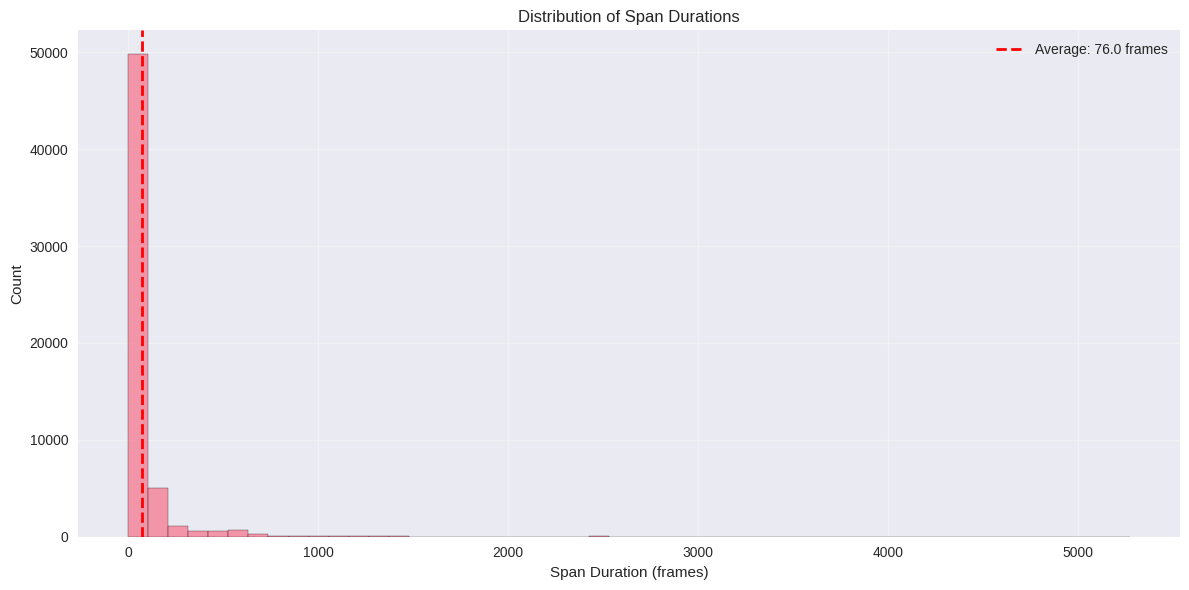

In [23]:
if len(all_span_durations) > 0:
    plt.figure(figsize=(12, 6))
    plt.hist(all_span_durations, bins=50, alpha=0.7, edgecolor='black')
    plt.axvline(all_span_durations.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Average: {all_span_durations.mean():.1f} frames')
    plt.xlabel('Span Duration (frames)')
    plt.ylabel('Count')
    plt.title('Distribution of Span Durations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("No spans to plot!")

<div class="alert alert-info">

#### **Number of Prompts per Motion**

</div>


=== Prompts per Motion Analysis ===
Average prompts per motion: 6.68
Median prompts per motion: 5.00
Min prompts per motion: 1
Max prompts per motion: 89


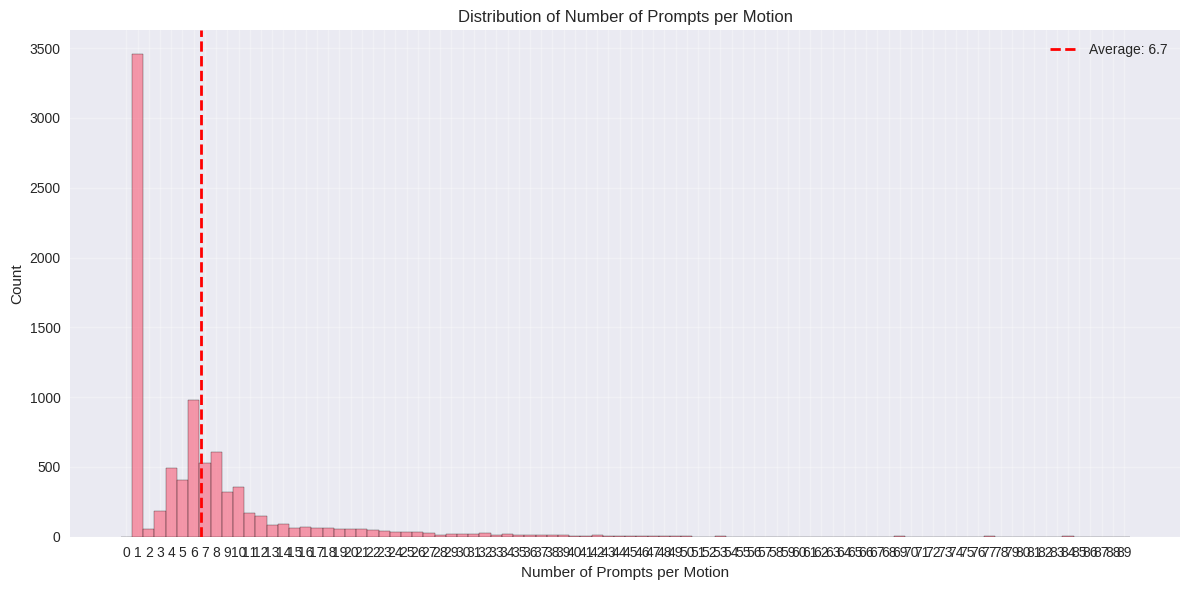

In [24]:
print("\n=== Prompts per Motion Analysis ===")
print(f"Average prompts per motion: {num_prompts_per_motion.mean():.2f}")
print(f"Median prompts per motion: {np.median(num_prompts_per_motion):.2f}")
print(f"Min prompts per motion: {num_prompts_per_motion.min()}")
print(f"Max prompts per motion: {num_prompts_per_motion.max()}")

plt.figure(figsize=(12, 6))
plt.hist(num_prompts_per_motion, bins=range(int(num_prompts_per_motion.max()) + 2), 
         alpha=0.7, edgecolor='black', align='left')
plt.axvline(num_prompts_per_motion.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Average: {num_prompts_per_motion.mean():.1f}')
plt.xlabel('Number of Prompts per Motion')
plt.ylabel('Count')
plt.title('Distribution of Number of Prompts per Motion')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(int(num_prompts_per_motion.max()) + 1))
plt.tight_layout()
plt.show()

<div class="alert alert-warning">

TODO: i believe there is something wrong in the plot below as the average is the same as the number of prompts while it shouldn't be i think.

</div>

In [25]:
# Let's recalculate spans per prompt more accurately
# We need to track individual prompts and their associated spans

def extract_prompts_and_spans(sample, fps=20):
    """Extract prompts with their associated spans"""
    prompts_with_spans = []
    
    # Process sequence annotations
    seq_labels = sample['sequence_annotations'].get('labels', [])
    if isinstance(seq_labels, list):
        for label in seq_labels:
            if 'proc_label' in label and 'start_t' in label and 'end_t' in label:
                prompt = label['proc_label']
                start_frame = int(label['start_t'] * fps)
                end_frame = int(label['end_t'] * fps)
                if end_frame > start_frame:
                    prompts_with_spans.append((prompt, start_frame, end_frame))
    elif isinstance(seq_labels, dict):
        if all(key in seq_labels for key in ['proc_label', 'start_t', 'end_t']):
            for prompt, start_t, end_t in zip(seq_labels['proc_label'], seq_labels['start_t'], seq_labels['end_t']):
                start_frame = int(start_t * fps)
                end_frame = int(end_t * fps)
                if end_frame > start_frame:
                    prompts_with_spans.append((prompt, start_frame, end_frame))
    
    # Process frame annotations
    frame_labels = sample['frame_annotations'].get('labels', [])
    if isinstance(frame_labels, list):
        for label in frame_labels:
            if 'proc_label' in label and 'start_t' in label and 'end_t' in label:
                prompt = label['proc_label']
                start_frame = int(label['start_t'] * fps)
                end_frame = int(label['end_t'] * fps)
                if end_frame > start_frame:
                    prompts_with_spans.append((prompt, start_frame, end_frame))
    elif isinstance(frame_labels, dict):
        if all(key in frame_labels for key in ['proc_label', 'start_t', 'end_t']):
            for prompt, start_t, end_t in zip(frame_labels['proc_label'], frame_labels['start_t'], frame_labels['end_t']):
                start_frame = int(start_t * fps)
                end_frame = int(end_t * fps)
                if end_frame > start_frame:
                    prompts_with_spans.append((prompt, start_frame, end_frame))
    
    return prompts_with_spans

# Recalculate with proper prompt-span mapping
proper_spans_per_prompt = []
unique_prompts_spans = defaultdict(list)

print("Recalculating spans per prompt with proper mapping...")
for sample in tqdm.tqdm(combined_dataset, desc="Extracting prompt-span pairs"):
    prompts_with_spans = extract_prompts_and_spans(sample, fps=20)
    
    # Group spans by prompt text
    prompt_spans_count = defaultdict(int)
    for prompt, start_frame, end_frame in prompts_with_spans:
        prompt_spans_count[prompt] += 1
        unique_prompts_spans[prompt].append(end_frame - start_frame)
    
    # Add to our analysis
    for prompt, span_count in prompt_spans_count.items():
        proper_spans_per_prompt.append(span_count)

proper_spans_per_prompt = np.array(proper_spans_per_prompt)

print(f"\n=== Corrected Spans per Prompt Analysis ===")
if len(proper_spans_per_prompt) > 0:
    print(f"Total prompt instances with spans: {len(proper_spans_per_prompt)}")
    print(f"Average spans per prompt: {proper_spans_per_prompt.mean():.2f}")
    print(f"Median spans per prompt: {np.median(proper_spans_per_prompt):.2f}")
    print(f"Min spans per prompt: {proper_spans_per_prompt.min()}")
    print(f"Max spans per prompt: {proper_spans_per_prompt.max()}")
    
    # Distribution of spans per prompt
    spans_distribution = Counter(proper_spans_per_prompt)
    print(f"\nDistribution of spans per prompt:")
    for spans_count, prompt_count in sorted(spans_distribution.items()):
        print(f"  {prompt_count} prompts have {spans_count} span(s)")
else:
    print("No prompt-span pairs found!")

Recalculating spans per prompt with proper mapping...


Extracting prompt-span pairs: 100%|██████████| 8808/8808 [08:37<00:00, 17.04it/s]


=== Corrected Spans per Prompt Analysis ===
Total prompt instances with spans: 34544
Average spans per prompt: 1.70
Median spans per prompt: 1.00
Min spans per prompt: 1
Max spans per prompt: 36

Distribution of spans per prompt:
  22742 prompts have 1 span(s)
  7795 prompts have 2 span(s)
  1692 prompts have 3 span(s)
  859 prompts have 4 span(s)
  422 prompts have 5 span(s)
  261 prompts have 6 span(s)
  167 prompts have 7 span(s)
  149 prompts have 8 span(s)
  98 prompts have 9 span(s)
  79 prompts have 10 span(s)
  57 prompts have 11 span(s)
  46 prompts have 12 span(s)
  33 prompts have 13 span(s)
  31 prompts have 14 span(s)
  24 prompts have 15 span(s)
  15 prompts have 16 span(s)
  18 prompts have 17 span(s)
  5 prompts have 18 span(s)
  10 prompts have 19 span(s)
  14 prompts have 20 span(s)
  6 prompts have 21 span(s)
  3 prompts have 22 span(s)
  4 prompts have 23 span(s)
  2 prompts have 25 span(s)
  1 prompts have 26 span(s)
  2 prompts have 27 span(s)
  2 prompts have 29

<div class="alert alert-info">

#### **Number of Spans per Motion**

</div>


=== Spans per Motion Analysis ===
Average spans per motion: 6.67
Median spans per motion: 5.00
Min spans per motion: 0
Max spans per motion: 89


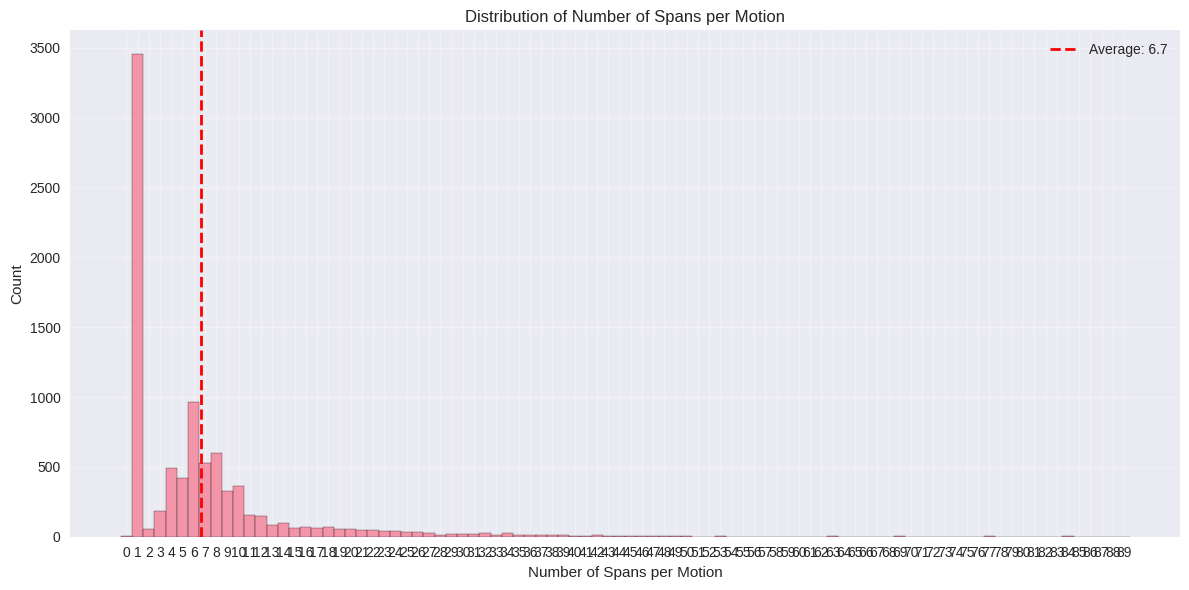

In [26]:
print("\n=== Spans per Motion Analysis ===")
print(f"Average spans per motion: {num_spans_per_motion.mean():.2f}")
print(f"Median spans per motion: {np.median(num_spans_per_motion):.2f}")
print(f"Min spans per motion: {num_spans_per_motion.min()}")
print(f"Max spans per motion: {num_spans_per_motion.max()}")

plt.figure(figsize=(12, 6))
plt.hist(num_spans_per_motion, bins=range(int(num_spans_per_motion.max()) + 2), 
         alpha=0.7, edgecolor='black', align='left')
plt.axvline(num_spans_per_motion.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Average: {num_spans_per_motion.mean():.1f}')
plt.xlabel('Number of Spans per Motion')
plt.ylabel('Count')
plt.title('Distribution of Number of Spans per Motion')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(int(num_spans_per_motion.max()) + 1))
plt.tight_layout()
plt.show()

<div class="alert alert-warning">

TODO: fix below plot.

</div>

<div class="alert alert-info">

#### **Number of Spans per Prompt**

</div>


=== Spans per Prompt Analysis (Corrected) ===
Average spans per prompt: 1.70
Median spans per prompt: 1.00
Min spans per prompt: 1
Max spans per prompt: 36


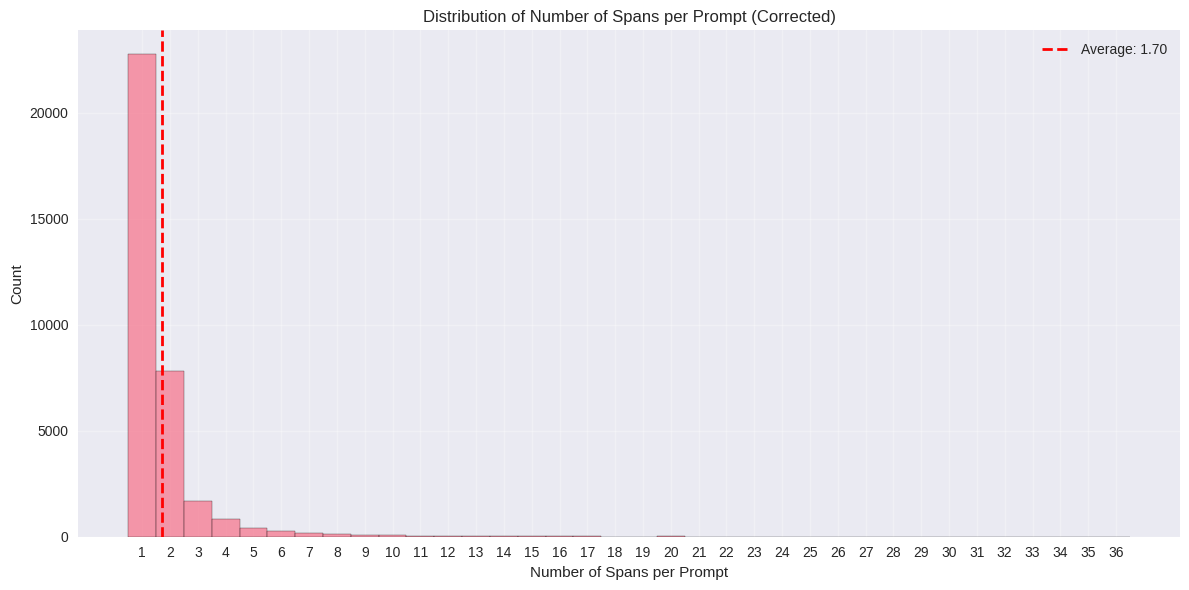

In [27]:
# 5. Number of Spans per Prompt (using corrected data)
if len(proper_spans_per_prompt) > 0:
    print("\n=== Spans per Prompt Analysis (Corrected) ===")
    print(f"Average spans per prompt: {proper_spans_per_prompt.mean():.2f}")
    print(f"Median spans per prompt: {np.median(proper_spans_per_prompt):.2f}")
    print(f"Min spans per prompt: {proper_spans_per_prompt.min()}")
    print(f"Max spans per prompt: {proper_spans_per_prompt.max()}")
    
    plt.figure(figsize=(12, 6))
    bins = range(int(proper_spans_per_prompt.min()), int(proper_spans_per_prompt.max()) + 2)
    plt.hist(proper_spans_per_prompt, bins=bins, alpha=0.7, edgecolor='black', align='left')
    plt.axvline(proper_spans_per_prompt.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Average: {proper_spans_per_prompt.mean():.2f}')
    plt.xlabel('Number of Spans per Prompt')
    plt.ylabel('Count')
    plt.title('Distribution of Number of Spans per Prompt (Corrected)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(range(int(proper_spans_per_prompt.min()), int(proper_spans_per_prompt.max()) + 1))
    plt.tight_layout()
    plt.show()
else:
    print("\n=== No spans per prompt data to analyze ===")

In [28]:
# Compare old vs new calculation
print("\n=== Comparison of Calculation Methods ===")
print(f"Original method (incorrect):")
if len(num_spans_per_prompt) > 0:
    print(f"  Average spans per prompt: {num_spans_per_prompt.mean():.2f}")
    print(f"  This was calculated as: total_spans_in_motion / total_prompts_in_motion")
else:
    print("  No data from original method")

print(f"\nCorrected method:")
if len(proper_spans_per_prompt) > 0:
    print(f"  Average spans per prompt: {proper_spans_per_prompt.mean():.2f}")
    print(f"  This counts actual spans associated with each prompt")
    
    # Show breakdown
    spans_dist = Counter(proper_spans_per_prompt)
    print(f"\nBreakdown:")
    for spans_count in sorted(spans_dist.keys()):
        prompt_count = spans_dist[spans_count]
        percentage = (prompt_count / len(proper_spans_per_prompt)) * 100
        print(f"  {prompt_count} prompts ({percentage:.1f}%) have {spans_count} span(s)")
else:
    print("  No data from corrected method")

# Analysis of unique prompts and their span patterns
print(f"\n=== Unique Prompt Analysis ===")
print(f"Total unique prompts found: {len(unique_prompts_spans)}")

# Find prompts with multiple spans
multi_span_prompts = {prompt: spans for prompt, spans in unique_prompts_spans.items() if len(spans) > 1}
print(f"Unique prompts with multiple spans: {len(multi_span_prompts)}")

if len(multi_span_prompts) > 0:
    print(f"\nTop 10 prompts with most spans:")
    sorted_multi_span = sorted(multi_span_prompts.items(), key=lambda x: len(x[1]), reverse=True)
    for prompt, spans in sorted_multi_span[:10]:
        print(f"  '{prompt}': {len(spans)} spans (durations: {spans})")


=== Comparison of Calculation Methods ===
Original method (incorrect):
  Average spans per prompt: 1.00
  This was calculated as: total_spans_in_motion / total_prompts_in_motion

Corrected method:
  Average spans per prompt: 1.70
  This counts actual spans associated with each prompt

Breakdown:
  22742 prompts (65.8%) have 1 span(s)
  7795 prompts (22.6%) have 2 span(s)
  1692 prompts (4.9%) have 3 span(s)
  859 prompts (2.5%) have 4 span(s)
  422 prompts (1.2%) have 5 span(s)
  261 prompts (0.8%) have 6 span(s)
  167 prompts (0.5%) have 7 span(s)
  149 prompts (0.4%) have 8 span(s)
  98 prompts (0.3%) have 9 span(s)
  79 prompts (0.2%) have 10 span(s)
  57 prompts (0.2%) have 11 span(s)
  46 prompts (0.1%) have 12 span(s)
  33 prompts (0.1%) have 13 span(s)
  31 prompts (0.1%) have 14 span(s)
  24 prompts (0.1%) have 15 span(s)
  15 prompts (0.0%) have 16 span(s)
  18 prompts (0.1%) have 17 span(s)
  5 prompts (0.0%) have 18 span(s)
  10 prompts (0.0%) have 19 span(s)
  14 prompts (

<div class="alert alert-info">

#### **Prompts Analysis**

</div>

<div class="alert alert-warning">

TODO: fix prompt frequencies.

</div>


=== Unique Prompts Analysis ===
Total prompt instances: 58881
Unique prompts: 7738
Average occurrences per unique prompt: 7.61

Top 20 most common prompts:
 1. 'transition' - 14441 times
 2. 'stand' - 5122 times
 3. 'walk' - 4056 times
 4. 'tpose' - 2080 times
 5. 'walk forward' - 971 times
 6. 'turn around' - 811 times
 7. 'run' - 511 times
 8. 'apose' - 495 times
 9. 'sit' - 464 times
10. 'jump' - 460 times
11. 'stand up' - 434 times
12. 'turn right' - 416 times
13. 'turn left' - 408 times
14. 'turn' - 388 times
15. 'throw' - 313 times
16. 'sit down' - 306 times
17. 'dance' - 303 times
18. 'jog' - 289 times
19. 'step forward' - 264 times
20. 'step back' - 227 times


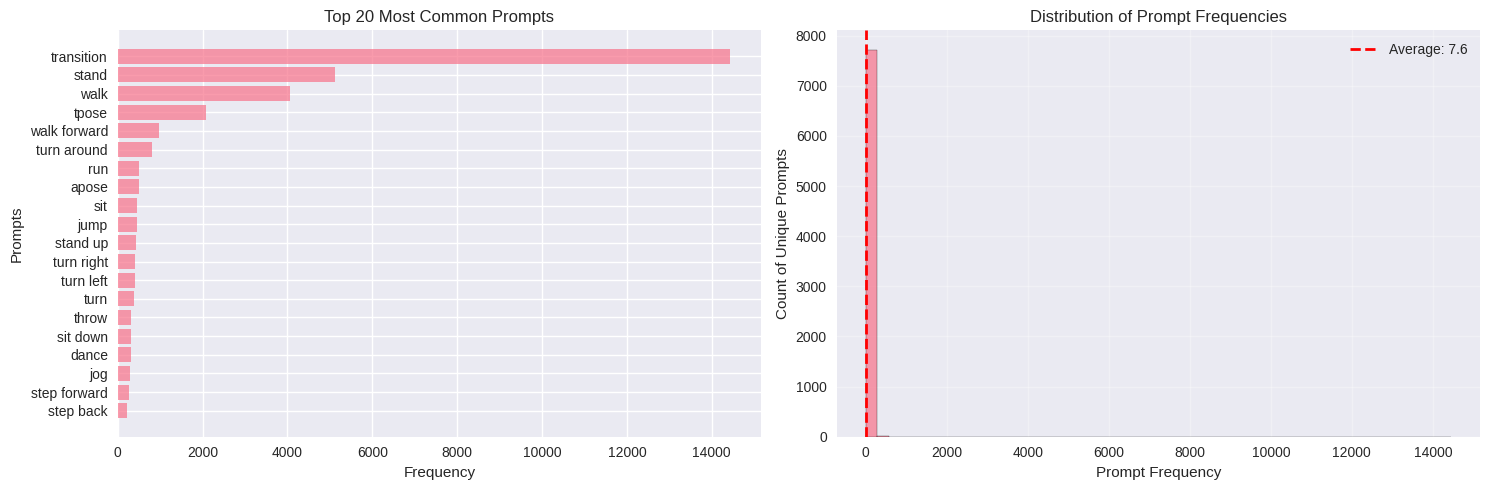

In [30]:
# 6. Unique Prompts Analysis
print("\n=== Unique Prompts Analysis ===")

# Count unique prompts
prompt_counter = Counter(all_prompt_texts)
total_prompts = len(all_prompt_texts)
unique_prompts = len(prompt_counter)

print(f"Total prompt instances: {total_prompts}")
print(f"Unique prompts: {unique_prompts}")
print(f"Average occurrences per unique prompt: {total_prompts/unique_prompts:.2f}")

# Get top 20 most common prompts
top_prompts = prompt_counter.most_common(20)
print("\nTop 20 most common prompts:")
for i, (prompt, count) in enumerate(top_prompts, 1):
    print(f"{i:2d}. '{prompt}' - {count} times")

# Plot distribution of prompt frequencies
frequencies = list(prompt_counter.values())
frequencies = np.array(frequencies)

plt.figure(figsize=(15, 5))

# Subplot 1: Top 20 prompts
plt.subplot(1, 2, 1)
prompts_text = [prompt[:30] + '...' if len(prompt) > 30 else prompt for prompt, _ in top_prompts]
counts = [count for _, count in top_prompts]
plt.barh(range(len(prompts_text)), counts, alpha=0.7)
plt.ylabel('Prompts')
plt.xlabel('Frequency')
plt.title('Top 20 Most Common Prompts')
plt.yticks(range(len(prompts_text)), prompts_text)
plt.gca().invert_yaxis()

# Subplot 2: Distribution of frequencies
plt.subplot(1, 2, 2)
plt.hist(frequencies, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(frequencies.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Average: {frequencies.mean():.1f}')
plt.xlabel('Prompt Frequency')
plt.ylabel('Count of Unique Prompts')
plt.title('Distribution of Prompt Frequencies')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<div class="alert alert-warning">

TODO: add total number of tokens and number of unique tokens in the prompts.
TODO: add associated act_cat

</div>

<div class="alert alert-info">

#### **Analysis**

</div>

<div class="alert alert-warning">

TODO: review the stats below and their interpretation as they seem very interesting; the span and prompt coverage.
TODO: this will maybe help us answer whether we should crop the amass motion to only fir the babel dataset or not.

</div>

In [31]:
# 7. Additional Analysis: Motion vs Span Duration Relationship
print("\n=== Additional Analysis ===")

# Create a summary table
print("\n=== Summary Statistics ===")
print(f"{'Metric':<30} {'Mean':<10} {'Median':<10} {'Min':<8} {'Max':<8} {'Std':<10}")
print("-" * 76)
print(f"{'Motion Duration (frames)':<30} {motion_durations.mean():<10.1f} {np.median(motion_durations):<10.1f} {motion_durations.min():<8} {motion_durations.max():<8} {motion_durations.std():<10.1f}")
if len(all_span_durations) > 0:
    print(f"{'Span Duration (frames)':<30} {all_span_durations.mean():<10.1f} {np.median(all_span_durations):<10.1f} {all_span_durations.min():<8} {all_span_durations.max():<8} {all_span_durations.std():<10.1f}")
print(f"{'Prompts per Motion':<30} {num_prompts_per_motion.mean():<10.1f} {np.median(num_prompts_per_motion):<10.1f} {num_prompts_per_motion.min():<8} {num_prompts_per_motion.max():<8} {num_prompts_per_motion.std():<10.1f}")
print(f"{'Spans per Motion':<30} {num_spans_per_motion.mean():<10.1f} {np.median(num_spans_per_motion):<10.1f} {num_spans_per_motion.min():<8} {num_spans_per_motion.max():<8} {num_spans_per_motion.std():<10.1f}")

# Coverage analysis
if len(all_span_durations) > 0 and len(motion_durations) > 0:
    print("\n=== Coverage Analysis ===")
    print(f"Motions with no spans: {np.sum(num_spans_per_motion == 0)} ({100 * np.sum(num_spans_per_motion == 0) / len(num_spans_per_motion):.1f}%)")
    print(f"Motions with prompts but no spans: {np.sum((num_prompts_per_motion > 0) & (num_spans_per_motion == 0))}")
    
    # Calculate span coverage ratio (total span duration / motion duration)
    span_coverage_ratios = []
    for i, sample in enumerate(combined_dataset):
        motion_duration = motion_durations[i]
        sample_spans = extract_spans_from_annotations(sample['sequence_annotations'], fps=20) + \
                      extract_spans_from_annotations(sample['frame_annotations'], fps=20)
        
        total_span_duration = sum(end - start for start, end in sample_spans if end > start)
        coverage_ratio = total_span_duration / motion_duration if motion_duration > 0 else 0
        span_coverage_ratios.append(coverage_ratio)
    
    span_coverage_ratios = np.array(span_coverage_ratios)
    print(f"Average span coverage ratio: {span_coverage_ratios.mean():.3f} ({100 * span_coverage_ratios.mean():.1f}%)")
    print(f"Median span coverage ratio: {np.median(span_coverage_ratios):.3f} ({100 * np.median(span_coverage_ratios):.1f}%)")


=== Additional Analysis ===

=== Summary Statistics ===
Metric                         Mean       Median     Min      Max      Std       
----------------------------------------------------------------------------
Motion Duration (frames)       244.9      130.0      1        5272     330.1     
Span Duration (frames)         76.0       27.0       1        5272     181.6     
Prompts per Motion             6.7        5.0        1        89       8.2       
Spans per Motion               6.7        5.0        0        89       8.2       

=== Coverage Analysis ===
Motions with no spans: 2 (0.0%)
Motions with prompts but no spans: 2


KeyboardInterrupt: 